# Radon preprocessing

In [1]:
# importing libraries
import pandas as pd
import numpy as np
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import contextily as ctx
import matplotlib.colors as mcolors
#from preprocessing import summary_plot
#import config
import os


import numpy as np
import statsmodels.api as sm
import pylab as py
import contextily as ctx


from scipy import stats
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")
%matplotlib inline

C:\Users\klasique computers\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\klasique computers\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
C:\ProgramData\Anaconda3\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
#os.getcwd()
# data counts
shapefile_dir = "Data/Radon raw/"
shapefiles = [os.path.join(shapefile_dir, f) for f in os.listdir(shapefile_dir) if f.endswith('.shp')]

project_crs = "EPSG:25832"  
dataframes = {}
data_count = 0

for shapefile in shapefiles:
    filename = os.path.splitext(os.path.basename(shapefile))[0]
    gdf = gpd.read_file(shapefile)
    gdf = gdf.to_crs(project_crs)
    dataframes[filename] = gdf
    print("Filename:", os.path.basename(shapefile))
    print("CRS:", gdf.crs)
    print("Number of Rows:", len(gdf))
    print()
    num_rows = len(gdf)
    data_count += num_rows

print(f"Total Rows for all Shapefiles: {data_count}")

Filename: Bodenluftmessungen_new.shp
CRS: epsg:25832
Number of Rows: 696

Filename: Bodenluftmessu_weitere.shp
CRS: epsg:25832
Number of Rows: 255

Filename: Datai_Wolfskehlen.shp
CRS: epsg:25832
Number of Rows: 676

Filename: Rn_Leinhardt.shp
CRS: epsg:25832
Number of Rows: 208

Total Rows for all Shapefiles: 1835


In [3]:
def rename_column(dataframe: pd.DataFrame):
    renamed_cols = ['Eastings','Northings','GRP', 'Radon_222','geometry']
    renamed_df=dataframe.rename(columns=dict(zip(dataframe.columns,renamed_cols)))
    return renamed_df


def summary(df: pd.DataFrame):

    summary_df = pd.DataFrame(df.dtypes, columns=['Data Type'])
    summary_df['Missing Values'] = df.isnull().sum().values
    summary_df['Precent missing'] = df.isnull().sum().values / len(df)* 100
    summary_df['Unique values'] = df.nunique().values
    describe = pd.DataFrame(df.describe(include='all').transpose())
    summary_df['Minimum'] = describe['min'].values
    summary_df['Maximum'] = describe['max'].values

    return summary_df

def ID_outliers(df: pd.DataFrame):
    Q1=df['GRP'].quantile(0.25)
    Q3=df['GRP'].quantile(0.75)
    IQR=Q3-Q1
    lower_bound=Q1-1.5*IQR
    upper_bound=Q3+1.5*IQR
    outliers = df[(df['GRP']<lower_bound)|(df['GRP']>upper_bound)]
    if not outliers.empty:
        return pd.DataFrame(outliers)
    #    print(f'{df} No outliers detected')
    else:
        print('No outliers detected')
        

def process_data(data):
    data['GRP']=data.GRP.str.replace(',', '.')
    data['GRP']=pd.to_numeric(data['GRP'], errors='coerce')
    data['GRP'].dropna(inplace=True)
    processed_data = data[data['GRP']>0]
    return processed_data

def summary_plt(data, str:None):
    #data=dataframe['RADONPOTEN']
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    # boxplot
    ax[0].boxplot(data, vert=True)
    ax[0].set_title(f'Boxplot of GRP ${[str]}$')
    # histogram
    ax[1].hist(data, bins=20, alpha=0.5, color='blue', orientation='vertical')
    ax[1].set_title(f'Histogram of GRP ${[str]}$')
    # QQ plot
    stats.probplot(data, dist="norm", plot=ax[2])
    ax[2].set_title(f'QQ Plot of GRP ${[str]}$')


In [4]:
Bodenluftmessungen_new=dataframes['Bodenluftmessungen_new']\
                                 [['OSTWERT', 'NORDWERT','RADONPOTEN',
                                  'RADON_RN_2','geometry']]

Bodenluftmessu_weitere=dataframes['Bodenluftmessu_weitere']\
                                 [['OSTWERT', 'NORDWERT', 'RADONPOTEN',
                                 'RADON_RN_2','geometry']]

Datai_Wolfskehlen=dataframes['Datai_Wolfskehlen']\
                            [["Koordinate","Koordina_1",
                              "Rn",'geometry']]

survey_Leinhardt=dataframes['Rn_Leinhardt']\
                           [["GPS","Field3","Permeabili",
                          "Rn__slow_",'geometry']]

data1 = rename_column(Bodenluftmessungen_new)
data_2 = rename_column(Bodenluftmessu_weitere)
data2 = process_data(data_2)

data_2.shape
#Bodenluftmessu_weitere.RADONPOTEN

(255, 5)

In [5]:
data_sets = [
    ("Bodenluftmessungen_new", Bodenluftmessungen_new),
    ("Bodenluftmessu_weitere", Bodenluftmessu_weitere),
    ("Datai_Wolfskehlen", Datai_Wolfskehlen),
    ("survey_Leinhardt", survey_Leinhardt)]

for title, data in data_sets:
    print(f"{title} Summary")
    print('-'*80)
    #print(data.describe().to_string())  
    print(summary(data).to_string())  
    print('\n'+'='*80+'\n')

Bodenluftmessungen_new Summary
--------------------------------------------------------------------------------
           Data Type  Missing Values  Precent missing  Unique values     Minimum       Maximum
OSTWERT      float64               0              0.0            695  414476.771      584540.0
NORDWERT     float64               0              0.0            695   5477873.0  5705172.4798
RADONPOTEN   float64               0              0.0            693         0.0    321.311491
RADON_RN_2   float64               0              0.0            624         0.0      549651.0
geometry    geometry               0              0.0            695         NaN           NaN


Bodenluftmessu_weitere Summary
--------------------------------------------------------------------------------
           Data Type  Missing Values  Precent missing  Unique values    Minimum       Maximum
OSTWERT      float64               0         0.000000            240   459776.0   544633.7902
NORDWERT     flo

In [6]:
#Wolfshehlen 
Datai_Wolfskehlen['Rn3'] = Datai_Wolfskehlen['Rn'] / 1000
Datai_Wolfskehlen['GRP'] = Datai_Wolfskehlen['Rn3'] / (-(np.log10(1e-11)) - 10)
data3 = rename_column(Datai_Wolfskehlen[["Koordinate", "Koordina_1", "GRP", "Rn", "geometry"]])

#Leinhardt
survey_Leinhardt['Rn3'] = survey_Leinhardt['Rn__slow_']/1000
survey_Leinhardt['Permeabili'] = survey_Leinhardt['Permeabili']*-10**-11
survey_Leinhardt['GRP'] = survey_Leinhardt['Rn3']/(-(np.log10(survey_Leinhardt['Permeabili'])) -(10))
survey_Leinhardt_subset = survey_Leinhardt[["GPS","Field3","GRP","Rn__slow_",'geometry']]
data4 = rename_column(survey_Leinhardt_subset)

BHR Summary plots


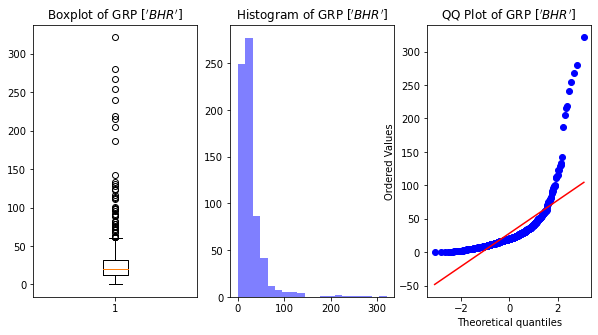

--------------------------------------------------------------------------------
BW Summary plots


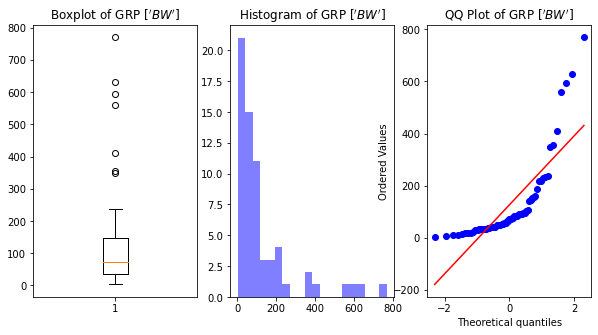

--------------------------------------------------------------------------------
Leinhardt Summary plots


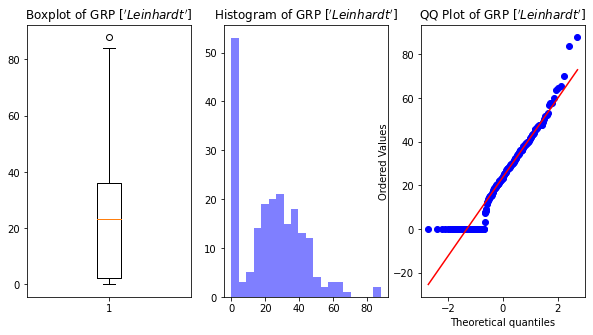

--------------------------------------------------------------------------------
Wolfskehlen Summary plots


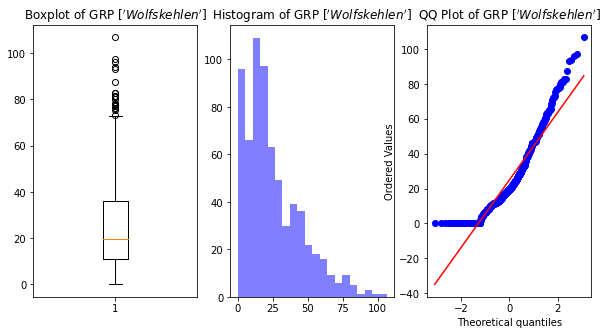

--------------------------------------------------------------------------------


In [7]:
data_sets = [(data1.GRP, 'BHR'),(data2.GRP, 'BW'),
             (data4.GRP, 'Leinhardt'),(data3.GRP, 'Wolfskehlen')]

for data, title in data_sets:
    print(f'{title} Summary plots')
    summary_plt(data, title)
    plt.show()  
    print('-' * 80)  

Total Rows for preprocessed Shapefiles: 1835
Total Rows for merged Shapefiles: 1645
Total Rows for processed Shapefiles: 1509


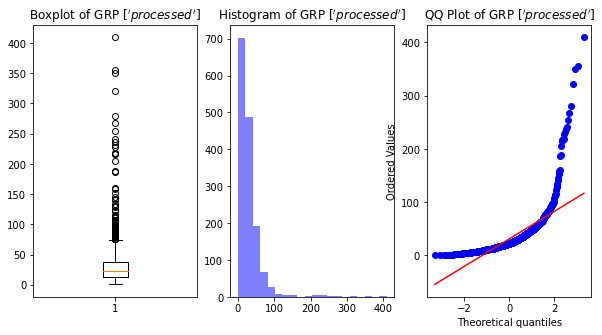

In [8]:
## Merging the dataframes
data12 = pd.concat([data1,data2], ignore_index=True)
data34 = pd.concat([data3,data4], ignore_index=True)
mergedf = pd.concat([data12,data34], ignore_index=True)

processed_dataa = mergedf[(mergedf['GRP'] > 0) & (mergedf['GRP'] < 500)]

#Features_of_interest.loc[Features_of_interest["Rn_Poten"] == 0]
#print(data12.shape)   #print(data34.shape)

print(f"Total Rows for preprocessed Shapefiles: {data_count}")
print(f"Total Rows for merged Shapefiles: {mergedf.shape[0]}")
print(f"Total Rows for processed Shapefiles: {processed_dataa.shape[0]}")

def GRP_intervals(df: pd.DataFrame):

    # risk categories according to hlnug and bfs
    conditions = [(df['GRP']< 22),(df['GRP']< 44),(df['GRP']> 44)]
    mapping = ['<22','22 - 44','>44']
    df['GRP_conc'] = np.select(conditions,mapping, default=0)
    return df

processed_data=GRP_intervals(processed_dataa)

summary_plt(processed_data.GRP, 'processed')

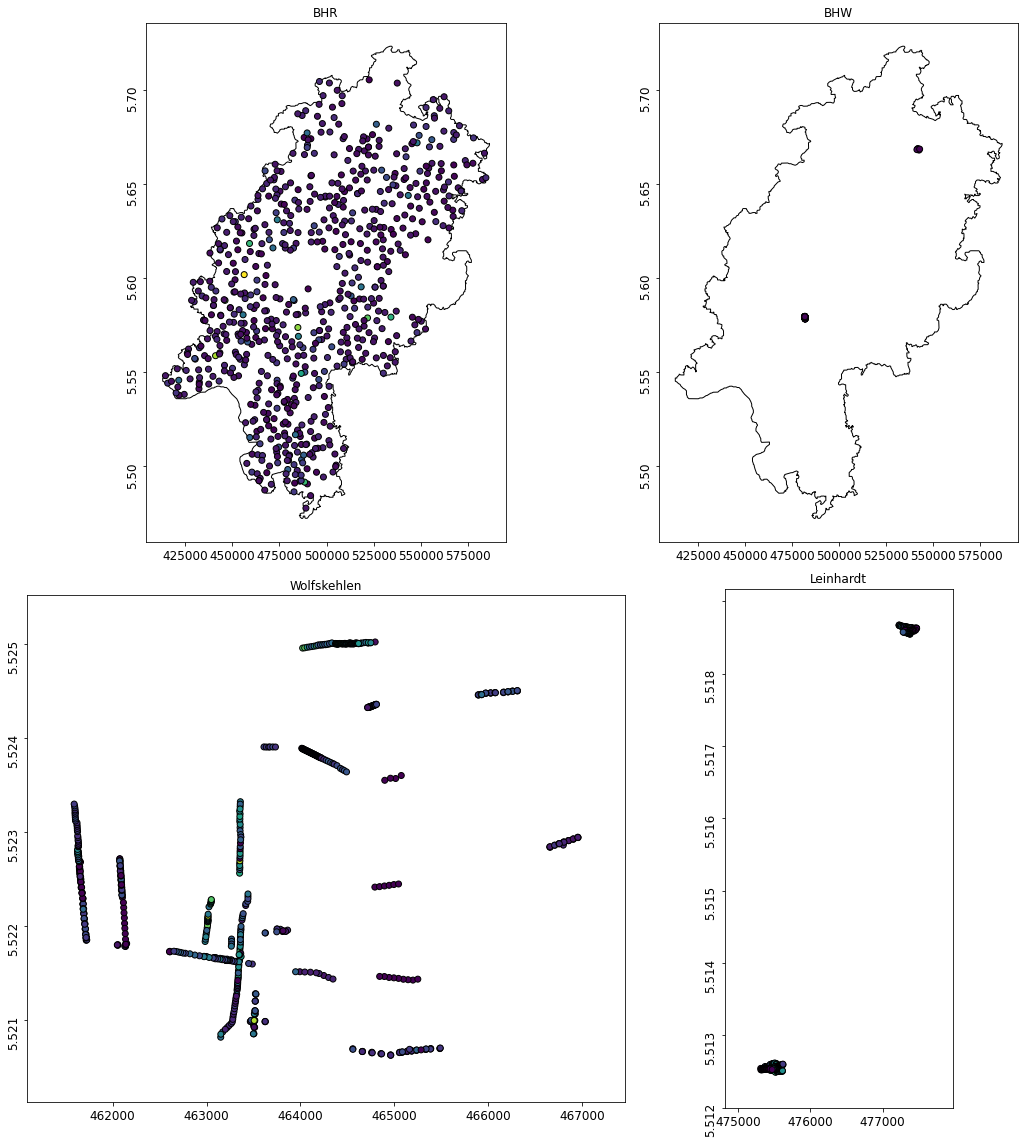

In [9]:
# Import AOI Hessen
Hessen = gpd.read_file('Data/Hessen_boundary/AOI_Hessen.shp')
fig, ax=plt.subplots(2,2, figsize = (16,16))

data_colors = {'Training':'green', 'Validation': 'red'}

# Scatter plot with different colors for each category

Hessen.plot(ax = ax[0,0], column = 'ID_0',
                  facecolor="none", edgecolor="black")
data1.plot(ax = ax[0,0],column = 'GRP', 
             edgecolor='black')
ax[0,0].xaxis.set_tick_params(labelsize=12)
ax[0,0].yaxis.set_tick_params(labelsize=12)
ax[0,0].ticklabel_format(useOffset= False, style='plain')
ax[0,0].set_title('BHR')
ax[0,0].set_yticklabels(ax[0,0].get_yticklabels(), rotation=90)


#*************************************************************************************************
## BHW
#*************************************************************************************************

axBHW = data2.plot(ax = ax[0,1],column = 'GRP', 
             edgecolor='black')

axBHW = Hessen.plot(ax = ax[0,1], column = 'ID_0',
                  facecolor="none", edgecolor="black")
ax[0,1].xaxis.set_tick_params(labelsize=12)
ax[0,1].yaxis.set_tick_params(labelsize=12)
ax[0,1].ticklabel_format(useOffset= False, style='plain')
ax[0,1].set_title('BHW')
#plt.yticks(color='black', rotation=90)
ax[0,1].set_yticklabels(ax[0,1].get_yticklabels(), rotation=90)


#*************************************************************************************************
## Wolfskhelen
#*************************************************************************************************

Wolfsk = data3.plot(ax = ax[1,0],column = 'GRP',
             edgecolor='black',)
ax[1,0].xaxis.set_tick_params(labelsize=12)
ax[1,0].yaxis.set_tick_params(labelsize=12)
ax[1,0].ticklabel_format(useOffset= False, style='plain')
ax[1,0].set_xlim(data3['Eastings'].min()-500, data3['Eastings'].max()+500)
ax[1,0].set_ylim(data3['Northings'].min()-500, data3['Northings'].max()+500)
ax[1,0].set_title('Wolfskehlen')
ax[1,0].set_yticklabels(ax[1,0].get_yticklabels(), rotation=90)

#=====================================================================================================

#*************************************************************************************************
## Leinhardt
#*************************************************************************************************

Leinhardt = data4.plot(ax = ax[1,1],column = 'GRP',
             edgecolor='black')
ax[1,1].xaxis.set_tick_params(labelsize=12)
ax[1,1].yaxis.set_tick_params(labelsize=12)
ax[1,1].ticklabel_format(useOffset= False, style='plain')
ax[1,1].set_xlim(data4['Eastings'].min()-500, data4['Eastings'].max()+500)
ax[1,1].set_ylim(data4['Northings'].min()-500, data4['Northings'].max()+500)
ax[1,1].set_title('Leinhardt')
ax[1,1].set_yticklabels(ax[1,1].get_yticklabels(), rotation=90)

#plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.35)

#plt.margins(x=0)
plt.tight_layout()
plt.show()

#=====================================================================================================

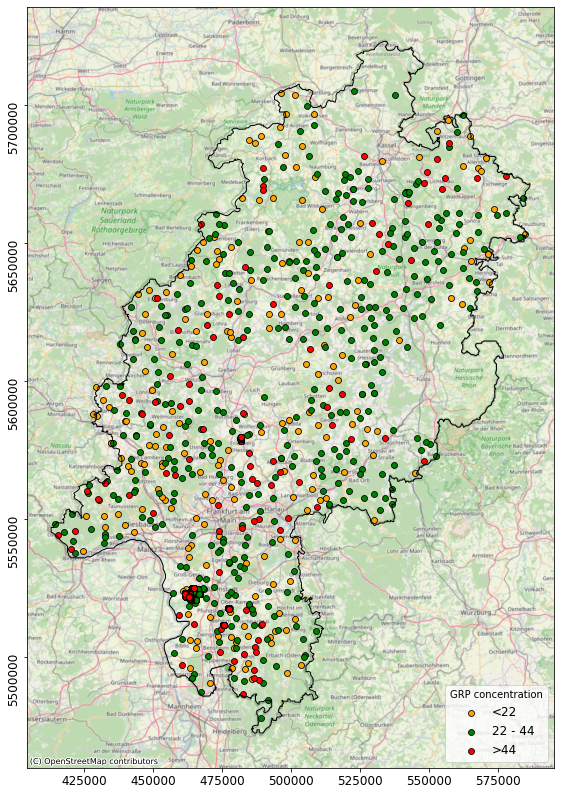

In [10]:
fig, ax=plt.subplots(figsize = (14,14))

data_colors = {'<22':'green', '22 - 44': 'orange',
               '>44': 'red'}
grouped_plt = processed_data.groupby('GRP_conc')
for key, group in grouped_plt:
    group.plot(ax=ax,color=data_colors[key], linewidth=0.8, edgecolor='black')

ax3 = Hessen.plot(ax = ax, column = 'ID_0',
                  facecolor="none", edgecolor="black")
ax.ticklabel_format(useOffset= False, style='plain')
for label in ax.get_xticklabels():
    label.set_horizontalalignment('center')
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.yticks(color='black', rotation=90)
plt.legend(['<22','22 - 44', '>44'],
           fontsize=12,loc= 'lower right',  title="GRP concentration")#, )
ctx.add_basemap(ax, crs=processed_data.crs, source=ctx.providers.OpenStreetMap.Mapnik)
plt.show()
#fig.savefig(fig_path+"traintest.png", dpi=350)
